上⼀节介绍了循环神经⽹络中的梯度计算⽅法。我们发现，当时间步数较⼤或者时间步较⼩时，循环神经⽹络的梯度较容易出现衰减或爆炸。虽然裁剪梯度可以应对梯度爆炸，但⽆法解决梯度衰减的问题。通常由于这个原因，循环神经⽹络在实际中较难捕捉时间序列中时间步距离较⼤的依赖关系。

⻔控循环神经⽹络（gated recurrent neural network）的提出，正是为了更好地捕捉时间序列中时间步距离较⼤的依赖关系。它通过可以学习的⻔来控制信息的流动。

# 门控循环单元

## 重置门和更新门

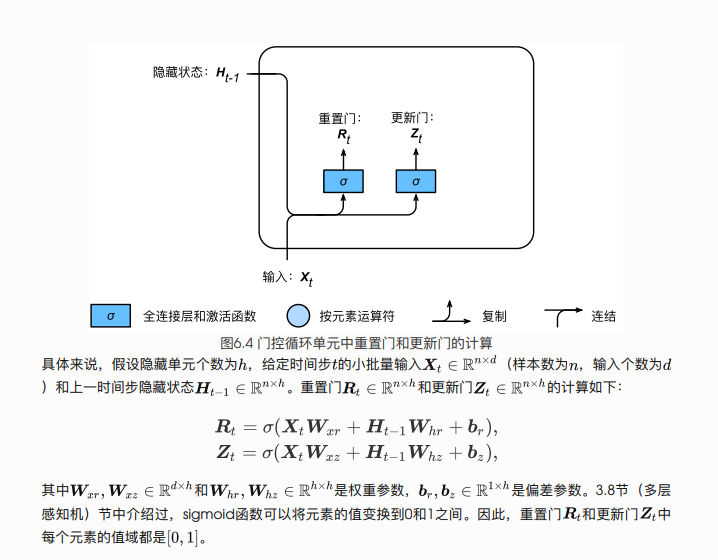

## 候选隐藏状态

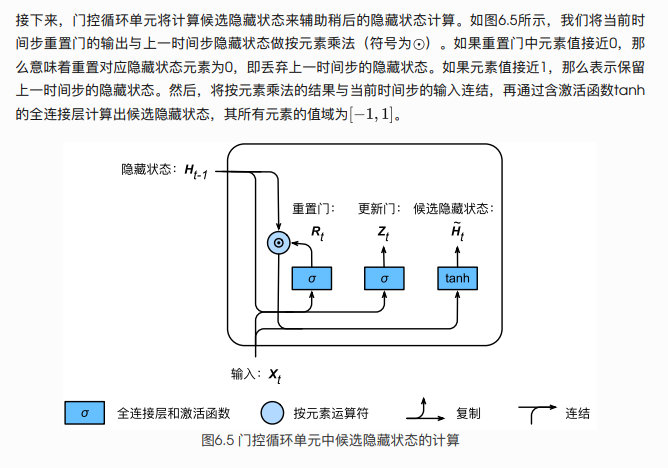
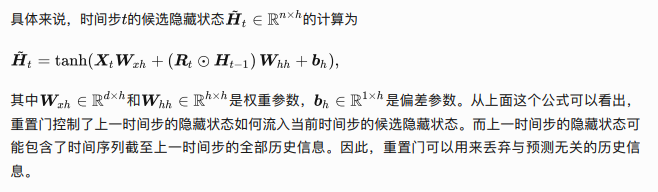

## 隐藏状态

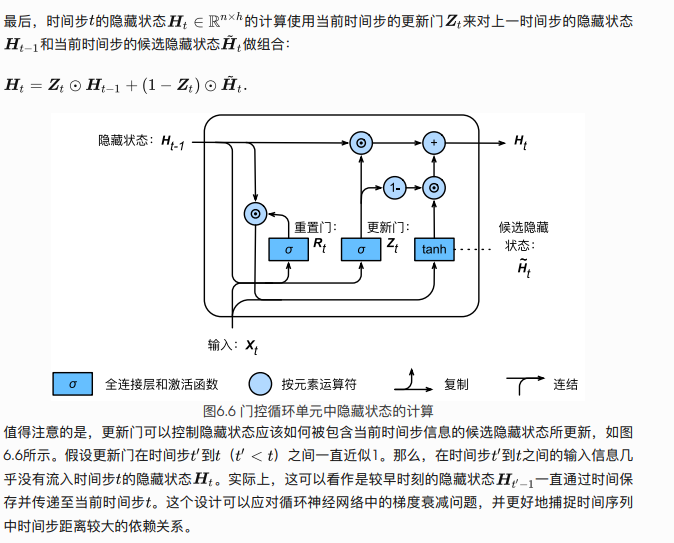

# 读取数据集

In [13]:
import time
import math
import numpy as np
import torch
import random
from torch import nn,optim
import torch.nn.functional as F

import sys

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
import zipfile
with zipfile.ZipFile('./Datasets/jaychou_lyrics.txt.zip') as zin:
    with zin.open('jaychou_lyrics.txt') as f:
        corpus_chars=f.read().decode('utf-8')
corpus_chars=corpus_chars.replace('\n',' ').replace('\r',' ')
corpus_chars=corpus_chars[0:10000]
idx_to_char=list(set(corpus_chars))
char_to_idx=dict([(char,i) for i,char in enumerate(idx_to_char)])
vocab_size=len(char_to_idx)
corpus_indices=[char_to_idx[char] for char in corpus_chars]

# 从零开始实现

## 初始化模型参数

In [15]:
num_inputs,num_hiddens,num_outputs=vocab_size,256,vocab_size
print('will use',device)
def get_params():
    def _one(shape):
        ts=torch.tensor(np.random.normal(0,0.01,size=shape),device=device,dtype=torch.float32)
        return torch.nn.Parameter(ts,requires_grad=True)
    def _three():
        return (_one((num_inputs,num_hiddens)),
               _one((num_hiddens,num_hiddens)),
               torch.nn.Parameter(torch.zeros(num_hiddens,device=device,dtype=torch.float32),requires_grad=True))
    W_xz,W_hz,b_z=_three()
    W_xr,W_hr,b_r=_three()
    W_xh,W_hh,b_h=_three()
    
    W_hq=_one((num_hiddens,num_outputs))
    b_q=torch.nn.Parameter(torch.zeros(num_outputs,device=device,dtype=torch.float32),requires_grad=True)
    return nn.ParameterList([W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q])

will use cuda


## 定义模型

In [16]:
def init_gru_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [17]:
def gru(inputs,state,params):
    W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q=params
    H,=state
    outputs=[]
    for X in inputs:
        Z=torch.sigmoid(torch.matmul(X,W_xz)+torch.matmul(H,W_hz)+b_z)
        R=torch.sigmoid(torch.matmul(X,W_xr)+torch.matmul(H,W_hr)+b_r)
        H_tilda=torch.tanh(torch.matmul(X,W_xh)+R*torch.matmul(H,W_hh)+b_h)
        H=Z*H+(1-Z)*H_tilda
        Y=torch.matmul(H,W_hq)+b_q
        outputs.append(Y)
    return outputs,(H,)

## 训练模型并创作歌词

In [24]:
def one_hot(x,n_class,dtype=torch.float32):
    # X shape: (batch), output shape: (batch, n_class)
    x=x.long()
    res=torch.zeros(x.shape[0],n_class,dtype=dtype,device=x.device)
    res.scatter_(1,x.view(-1,1),1)
    return res
def to_onehot(X,n_class):
    # X shape: (batch, seq_len), output: seq_len elements of (batch,n_class)
    return [one_hot(X[:,i],n_class) for i in range(X.shape[1])]

In [18]:
def data_iter_consecutive(corpus_indices,batch_size,num_steps,device=None):
    if device is None:
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    corpus_indices=torch.tensor(corpus_indices,dtype=torch.float32,device=device)
    data_len=len(corpus_indices)
    batch_len=data_len//batch_size
    indices=corpus_indices[0:batch_size*batch_len].view(batch_size,batch_len)
    epoch_size=(batch_len-1)//num_steps
    for i in range(epoch_size):
        i=i*num_steps
        X=indices[:,i:i+num_steps]
        Y=indices[:,i+1:i+num_steps+1]
        yield X,Y

In [19]:
def grad_clipping(params,theta,device):
    norm=torch.tensor([0.0],device=device)
    for param in params:
        norm+=(param.grad.data**2).sum()
    norm=norm.sqrt().item()
    if norm>theta:
        for param in params:
            param.grad.data*=(theta/norm)

In [20]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size

In [26]:
def predict_rnn(prefix,num_chars,rnn,params,init_rnn_state,num_hiddens,vocab_size,device,idx_to_char,char_to_idx):
    state=init_rnn_state(1,num_hiddens,device)
    output=[char_to_idx[prefix[0]]]
    for t in range(num_chars+len(prefix)-1):
        X=to_onehot(torch.tensor([[output[-1]]],device=device),vocab_size)
        (Y,state)=rnn(X,state,params)
        if t<len(prefix)-1:
            output.append(char_to_idx[prefix[t+1]])
        else:
            output.append(int(Y[0].argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

In [21]:
def train_and_predict_rnn(rnn,get_params,init_rnn_state,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,is_random_iter,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes):
    if is_random_iter:
        data_iter_fn=data_iter_random
    else:
        data_iter_fn=data_iter_consecutive
    params=get_params()
    loss=nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        if not is_random_iter:# 如使⽤相邻采样，在epoch开始时初始化隐藏状态
            state=init_rnn_state(batch_size,num_hiddens,device)
        l_sum,n,start=0.0,0,time.time()
        data_iter=data_iter_fn(corpus_indices,batch_size,num_steps,device)
        for X,Y in data_iter:
            if is_random_iter:# 如使⽤随机采样，在每个⼩批量更新前初始化隐藏状态
                state=init_rnn_state(batch_size,num_hiddens,device)
            else:
                # 否则需要使⽤detach函数从计算图分离隐藏状态, 这是为了
                # 使模型参数的梯度计算只依赖⼀次迭代读取的⼩批量序列(防⽌梯度计算开销太⼤）
                for s in state:
                    s.detach_()
            inputs=to_onehot(X,vocab_size)
            (outputs,state)=rnn(inputs,state,params)
            outputs=torch.cat(outputs,dim=0)
            y=torch.transpose(Y,0,1).contiguous().view(-1)
            l=loss(outputs,y.long())
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params,clipping_theta,device)
            sgd(params,lr,1)
            l_sum+=l.item()*y.shape[0]
            n+=y.shape[0]
        if (epoch+1)%pred_period==0:
            print('epoch %d,perplexity %f,time %.2f sec'%(epoch+1,math.exp(l_sum/n),time.time()-start))
            for prefix in prefixes:
                print('-',predict_rnn(prefix,pred_len,rnn,params,init_rnn_state,num_hiddens,vocab_size,device,idx_to_char,char_to_idx))

In [40]:
num_epochs,num_steps,batch_size,lr,clipping_theta=160,35,32,1e2,1e-2
pred_period,pred_len,prefixes=40,50,['爱','恨']

In [27]:
train_and_predict_rnn(gru,get_params,init_gru_state,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,False,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes)

epoch 40,perplexity 151.152186,time 0.76 sec
- 分开 我想你的让我想想想想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你
- 不分开 我想你的让我想想想想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你想你
epoch 80,perplexity 30.882957,time 0.75 sec
- 分开 一直我 别怪我 别你的话 快人在人 温人了空 快使用双截棍 哼哼哈兮 快使用双截棍 哼哼哈兮 快使
- 不分开  没有你在我有多  没有你在我有多  没有你在我有多  没有你在我有多  没有你在我有多  没有你
epoch 120,perplexity 4.765018,time 0.77 sec
- 分开我 一场云酒 再一直好 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害 你 靠着我的肩膀 你
- 不分开 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活
epoch 160,perplexity 1.425833,time 0.76 sec
- 分开 让后是你在那南么 就是开不了口让她知道 我一定会呵护著你 也是你笑 你对我有多重要 我后悔没让你知
- 不分开 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活


# 简洁实现

In [29]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer,vocab_size):
        super(RNNModel,self).__init__()
        self.rnn=rnn_layer
        self.hidden_size=rnn_layer.hidden_size*(2 if rnn_layer.bidirectional else 1)
        self.vocab_size=vocab_size
        self.dense=nn.Linear(self.hidden_size,vocab_size)
        self.state=None
    def forward(self,inputs,state):
        #inputs: (batch, seq_len)
        X=to_onehot(inputs,self.vocab_size)
        Y,self.state=self.rnn(torch.stack(X),state)
        output=self.dense(Y.view(-1,Y.shape[-1]))
        return output,self.state      

In [33]:
def predict_rnn_pytorch(prefix,num_chars,model,vocab_size,device,idx_to_char,char_to_idx):
    state=None
    output=[char_to_idx[prefix[0]]]
    for t in range(num_chars+len(prefix)-1):
        X=torch.tensor([output[-1]],device=device).view(1,1)
        if state is not None:
            if isinstance(state,tuple):
                state=(state[0].to(device),state[1].to(device))
            else:
                state=state.to(device)
        (Y,state)=model(X,state)
        if t<len(prefix)-1:
            output.append(char_to_idx[prefix[t+1]])
        else:
            output.append(int(Y.argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

In [34]:
def train_and_predict_rnn_pytorch(model,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes):
    loss=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    model.to(device)
    state=None
    for epoch in range(num_epochs):
        l_sum,n,start=0.0,0,time.time()
        data_iter=data_iter_consecutive(corpus_indices,batch_size,num_steps,device)
        for X,Y in data_iter:
            if state is not None:
                if isinstance(state,tuple):# LSTM, state:(h, c)
                    state=(state[0].detach(),state[1].detach())
                else:
                    state=state.detach()
            (output,state)=model(X,state)
            y=torch.transpose(Y,0,1).contiguous().view(-1)
            l=loss(output,y.long())
            optimizer.zero_grad()
            l.backward()
            grad_clipping(model.parameters(),clipping_theta,device)
            optimizer.step()
            l_sum+=l.item()*y.shape[0]
            n+=y.shape[0]
        try:
            perplexity=math.exp(l_sum/n)
        except OverflowError:
            perplexity=float('inf')
        if (epoch+1)%pred_period==0:
            print('epoch %d,perplexity %f,time %.2f sec '%(epoch+1,perplexity,time.time()-start))
            for prefixe in prefixes:
                print(' -',predict_rnn_pytorch(prefixe,pred_len,model,vocab_size,device,idx_to_char,char_to_idx))

In [41]:
lr=1e-2
gru_layer=nn.GRU(input_size=vocab_size,hidden_size=num_hiddens)
model=RNNModel(gru_layer,vocab_size).to(device)
train_and_predict_rnn_pytorch(model,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes)

epoch 40,perplexity 1.020760,time 0.30 sec 
 - 爱情走的太快就像龙卷风 不能承受我已无处可躲 我不要再想 我不要再想 我不 我不 我不要再想你 爱情来
 - 恨自然这迎著风 开始共渡每一天 手牵手 一步两步三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背
epoch 80,perplexity 1.011194,time 0.30 sec 
 - 爱你看棒球 想这样没担忧 唱着歌 一直走 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害 你 
 - 恨自己真的没用 情绪激动 一颗心到现在还在抽痛 还为分手前那句抱歉 在感动 穿梭时间的画面的钟 从反方
epoch 120,perplexity 1.012813,time 0.32 sec 
 - 爱你看棒球 想这样没担忧 唱着歌 一直走 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害 你 
 - 恨自己真的没用 情绪激动 一颗心到现在还在抽痛 还为分手前那句抱歉 在感动 穿梭时间的画面的钟 从反方
epoch 160,perplexity 1.015124,time 0.30 sec 
 - 爱情来的太快就像龙卷风 离不开暴风圈来不及逃 我不能再想 我不能再想 我不 我不 我不能 爱情走的太快
 - 恨自己真的没用 情绪激动 一颗心到现在还在抽痛 还为分手前那句抱歉 在感动 穿梭时间的画面的钟 从反方
